# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

# Описание проекта

В добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину. 

Шаги для выбора локации обычно такие:


- В избранном регионе собирают характеристики для скважин: качество нефти и объём её запасов;
  
- Строят модель для предсказания объёма запасов в новых скважинах;
  
- Выбирают скважины с самыми высокими оценками значений;
  
- Определяют регион с максимальной суммарной прибылью отобранных скважин.


Предоставлены пробы нефти в трёх регионах. Характеристики для каждой скважины в регионе уже известны. Построим модель для определения региона, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой Bootstrap.

# Описание данных

**id**  — уникальный идентификатор скважины;

**f0**,**f1**,**f2** — три признака точек (неважно, что они означают, но сами признаки значимы);

**product** — объём запасов в скважине (тыс. баррелей).

# Условия задачи:

Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).

При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.

Бюджет на разработку скважин в регионе — 10 млрд рублей.

При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.

После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.

Данные синтетические: детали контрактов и характеристики месторождений не разглашаются.

## Загрузка и подготовка данных

In [1]:
pip install --upgrade scikit-learn -q

Note: you may need to restart the kernel to use updated packages.


**Загружаем необходимые библиотеки**

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, root_mean_squared_error
from numpy.random import RandomState
from tqdm import tqdm
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.cluster import KMeans

**Открываем датасеты**

In [3]:
try:
    data_0 = pd.read_csv("geo_data_0.csv")
    data_1 = pd.read_csv('geo_data_1.csv')
    data_2 = pd.read_csv('geo_data_2.csv')
except:
    data_0 = pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_0.csv')
    data_1 = pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_1.csv')
    data_2 = pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_2.csv')

**Определяем функцию для вывода и проверки данных в датасете**

In [4]:
def data_check(df, name):
    print(f"Проверка данных: {name}")
    print("-"*100)
    print(f"Размер датасета: {df.shape}")
    print(df.info())
    print("\nПропуски в данных:")
    print(df.isnull().sum())
    print(f"\nКоличество дубликатов: {df.duplicated().sum()}")
    print(f"\nКоличество уникальных значений в 'id': {df['id'].nunique()}")
    print("\nОписание данных:")
    print(df.describe())
    print("-"*100)
    print("\n")

### Рассмотрим geo_data_0

In [5]:
data_check(data_0, "geo_data_0")

Проверка данных: geo_data_0
----------------------------------------------------------------------------------------------------
Размер датасета: (100000, 5)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None

Пропуски в данных:
id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

Количество дубликатов: 0

Количество уникальных значений в 'id': 99990

Описание данных:
                  f0             f1             f2        product
count  100000.000000  100000.000000  100000.000000  100000.000000
mean        0.500419       0.250143       2.502647      92.500000
std         0.871

**Проверяем на наличие дубликатов датасет data_0**

In [6]:
# Выявление дубликатов
duplicates_0 = data_0[data_0.duplicated(subset=['id'], keep=False)]

# Просмотр дублирующихся записей
print(duplicates_0.sort_values(by='id'))

          id        f0        f1         f2     product
66136  74z30  1.084962 -0.312358   6.990771  127.643327
64022  74z30  0.741456  0.459229   5.153109  140.771492
51970  A5aEY -0.180335  0.935548  -2.094773   33.020205
3389   A5aEY -0.039949  0.156872   0.209861   89.249364
69163  AGS9W -0.933795  0.116194  -3.655896   19.230453
42529  AGS9W  1.454747 -0.479651   0.683380  126.370504
931    HZww2  0.755284  0.368511   1.863211   30.681774
7530   HZww2  1.061194 -0.373969  10.430210  158.828695
63593  QcMuo  0.635635 -0.473422   0.862670   64.578675
1949   QcMuo  0.506563 -0.323775  -2.215583   75.496502
75715  Tdehs  0.112079  0.430296   3.218993   60.964018
21426  Tdehs  0.829407  0.298807  -0.049563   96.035308
92341  TtcGQ  0.110711  1.022689   0.911381  101.318008
60140  TtcGQ  0.569276 -0.104876   6.440215   85.350186
89582  bsk9y  0.398908 -0.400253  10.122376  163.433078
97785  bsk9y  0.378429  0.005837   0.160827  160.637302
41724  bxg6G -0.823752  0.546319   3.630479   93

Каждая строка имеет пару с одинаковым идентификатором, но данные в них различаются.

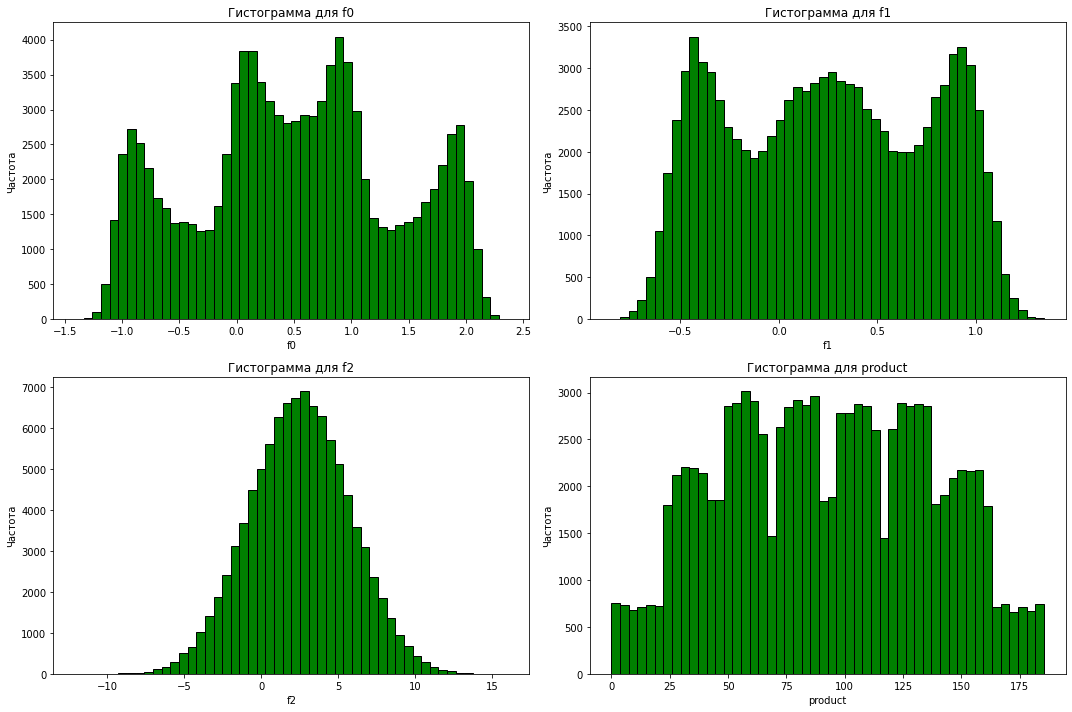

In [7]:
# Построим гистограммы для каждого признака

features = ['f0', 'f1', 'f2', 'product']

plt.figure(figsize=(15, 10))

for i, feature in enumerate(features):
    plt.subplot(2, 2, i+1)
    plt.hist(data_0[feature], bins=50, edgecolor='black', color='green')
    plt.title(f'Гистограмма для {feature}')
    plt.xlabel(feature)
    plt.ylabel('Частота')

plt.tight_layout()
plt.show()

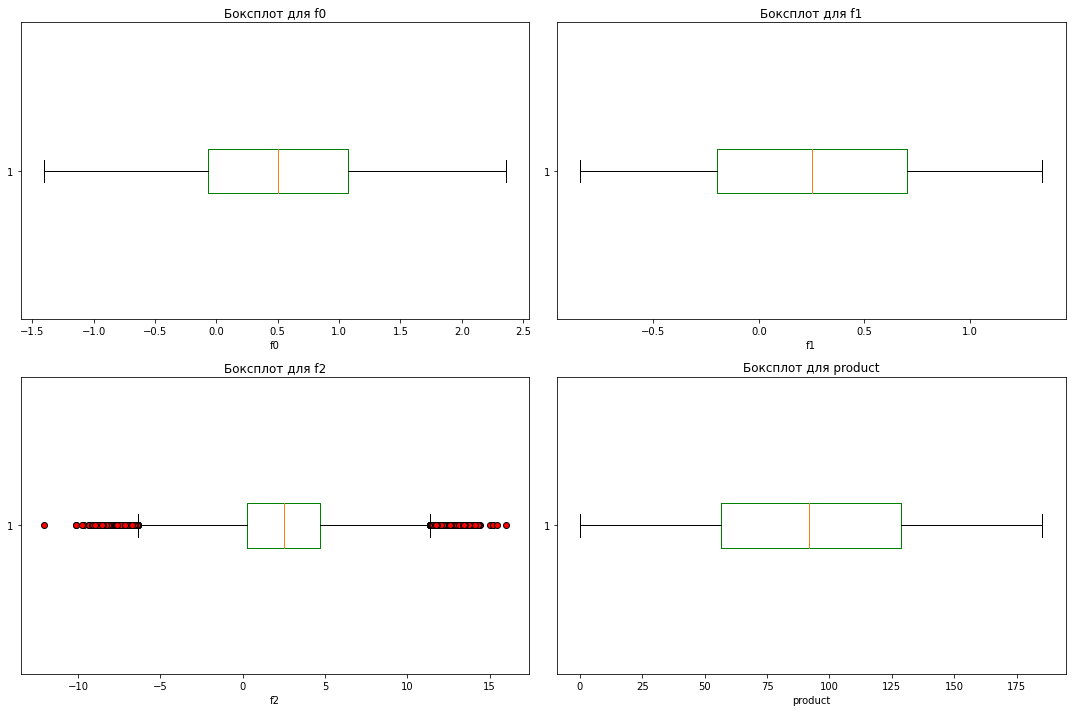

In [8]:
# Построим боксплоты для всех признаков

features = ['f0', 'f1', 'f2', 'product']

plt.figure(figsize=(15, 10))

for i, feature in enumerate(features):
    plt.subplot(2, 2, i+1)
    plt.boxplot(data_0[feature], vert=False, boxprops=dict(color='green'), \
                flierprops=dict(markerfacecolor='red', marker='o'))
    plt.title(f'Боксплот для {feature}')
    plt.xlabel(feature)

plt.tight_layout()
plt.show()

### Анализ признаков в `data_0`

#### 1. Признак `f0`

- Гистограмма:
Распределение признака `f0` демонстрирует многомодальность с несколькими отчетливыми пиками, что может свидетельствовать о наличии скрытых подгрупп или кластеров в данных.

- Боксплот:
Признак `f0` не содержит выбросов. Все значения находятся в пределах стандартных границ, и распределение данных симметрично.


**Вывод:**
Признак `f0` может быть подвержен воздействию различных факторов или категорий данных, однако выбросов в нем нет, что позволяет использовать его без дополнительной очистки от выбросов.

#### 2. Признак `f1`

- Гистограмма:
Признак `f1` также демонстрирует многомодальное распределение, что, как и в случае с `f0`, может указывать на наличие нескольких подгрупп в данных.

- Боксплот:
Признак `f1` не содержит выбросов, все значения находятся в пределах нормального диапазона.

**Вывод:**
Признак `f1` можно обрабатывать так же, как и `f0`, без необходимости удаления выбросов. Однако стоит учитывать возможные связи с разными подгруппами в данных.

#### 3. Признак `f2`

- Гистограмма:
Распределение признака `f2` близко к нормальному, с ярко выраженной симметрией вокруг среднего значения, что указывает на его предсказуемость в датасете.

- Боксплот:
Несмотря на нормальное распределение, бокс-плот показывает наличие значительного числа выбросов с обеих сторон, что может негативно повлиять на модель.

**Вывод:**
Хотя признак `f2` имеет нормальное распределение, присутствие множества выбросов требует их обработки, например, через удаление, преобразование или игнорирование в зависимости от природы этих выбросов.

#### 4. Признак `product`

- Гистограмма:
Признак `product` имеет многомодальное распределение, что может указывать на наличие различных категорий или кластеров в данных, характеризующихся разными объемами запасов нефти.

- Боксплот:
Признак `product` не содержит явных выбросов, что подтверждает, что его значения укладываются в ожидаемые пределы.

**Вывод:**
Признак `product`, будучи целевой переменной, не требует обработки выбросов, однако его многомодальность указывает на возможную необходимость учета нескольких подгрупп при прогнозировании.

**Построим матрицу корреляции**

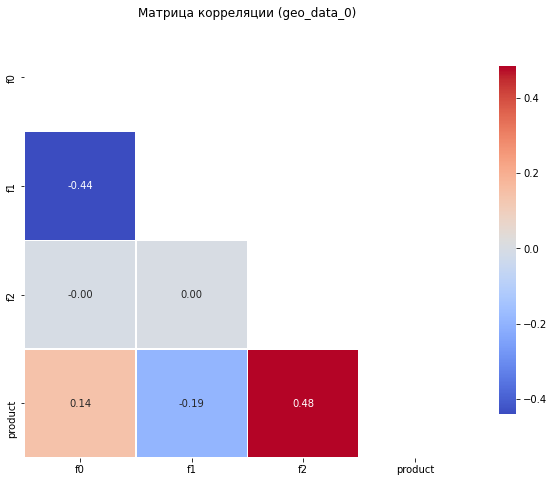

In [9]:
# Удаление столбца 'id' перед расчетом корреляции
data_0_numeric = data_0.drop(columns=['id'])

# Вычисление корреляционной матрицы
corr_matrix = data_0_numeric.corr()

# Построение маски для скрытия верхней треугольной части матрицы
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Настройка фигуры matplotlib
plt.figure(figsize=(10, 8))

# Построение тепловой карты с маской
sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='coolwarm', \
            fmt='.2f', linewidths=0.5, cbar_kws={"shrink": 0.8})
plt.title('Матрица корреляции (geo_data_0)')
plt.show()

**Рассчитаем показатель мультиколлинеарности VIF и визуализируем результаты**

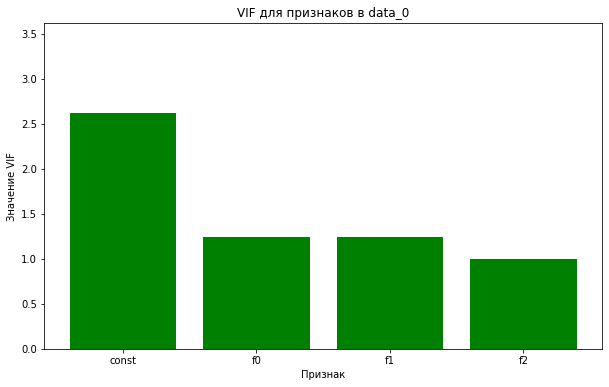

In [10]:
# Выбираем только числовые признаки
X = data_0[['f0', 'f1', 'f2']]

# Добавляем константу для расчета VIF
X = sm.add_constant(X)

# Расчет VIF для каждого признака
vif_data = pd.DataFrame()
vif_data['Feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Визуализация VIF
plt.figure(figsize=(10, 6))
plt.bar(vif_data['Feature'], vif_data['VIF'], color='green')
plt.title('VIF для признаков в data_0')
plt.xlabel('Признак')  # Подпись для оси X
plt.ylabel('Значение VIF')  # Подпись для оси Y
plt.ylim(0, max(vif_data['VIF']) + 1)
plt.axhline(y=5, color='blue', linestyle='--')
plt.show()

### Выводы по результатам анализа корреляции и VIF в `data_0`

#### 1. Матрица корреляции

- Корреляционная матрица показывает, что между признаками `f0`, `f1` и `f2` нет выраженной взаимосвязи. Коэффициенты корреляции варьируются от -0.03 до 0.45, что указывает на слабую корреляцию между ними. Это означает, что каждый из этих признаков может вносить уникальную информацию в модель, не дублируя другие.

#### 2. Проверка на мультиколлинеарность (VIF)

- Значения VIF для признаков `f0`, `f1` и `f2` значительно ниже критического уровня 5, что свидетельствует об отсутствии мультиколлинеарности.

    - Признак `f0`: VIF = 1.24
    - Признак `f1`: VIF = 1.24
    - Признак `f2`: VIF = 1.00

- Низкие значения VIF подтверждают, что данные признаки можно безопасно использовать в линейной регрессии без риска дестабилизации модели.

#### Общие выводы

- Признаки `f0`, `f1` и `f2` демонстрируют слабую взаимную корреляцию, что способствует тому, что каждый из них вносит независимый вклад в модель.

- Низкие значения VIF подтверждают отсутствие проблемы мультиколлинеарности, что позволяет включить все три признака в модель без необходимости их коррекции. 

Таким образом, признаки из набора данных `data_0` готовы для использования в моделировании без дополнительной обработки для устранения мультиколлинеарности или сильной корреляции.

**Построим диаграммы рассеяния для признаков f0 и product**

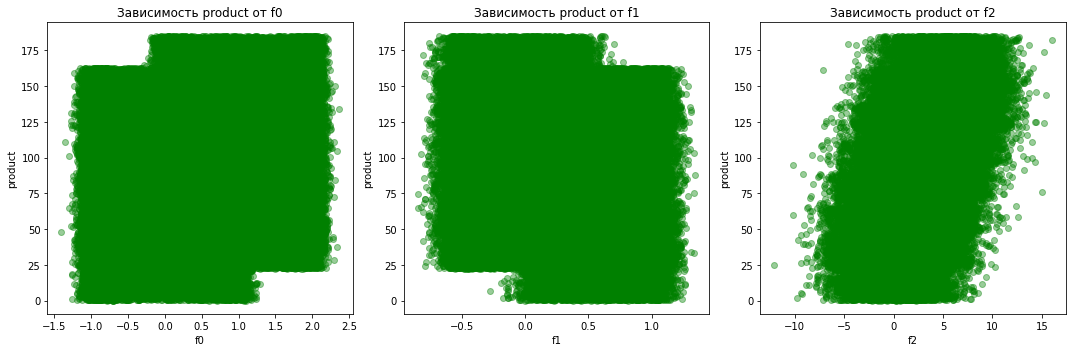

In [11]:
# Построение scatter plot для f0 и product
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.scatter(data_0['f0'], data_0['product'], alpha=0.4, color='green')
plt.title('Зависимость product от f0')
plt.xlabel('f0')
plt.ylabel('product')

# Построение scatter plot для f1 и product
plt.subplot(1, 3, 2)
plt.scatter(data_0['f1'], data_0['product'], alpha=0.4, color='green')
plt.title('Зависимость product от f1')
plt.xlabel('f1')
plt.ylabel('product')

# Построение scatter plot для f2 и product
plt.subplot(1, 3, 3)
plt.scatter(data_0['f2'], data_0['product'], alpha=0.4, color='green')
plt.title('Зависимость product от f2')
plt.xlabel('f2')
plt.ylabel('product')

plt.tight_layout()
plt.show()

### Результаты анализа взаимосвязей между признаками и целевой переменной  `product` в `data_0`

#### 1. Диаграммы рассеяния (Scatter Plots)

**f0 vs product:**

- Диаграмма рассеяния показывает, что между признаками `f0` и `product` нет явной линейной зависимости. Значения `product` распределены относительно равномерно по всему диапазону `f0`.

**f1 vs product:**

- Аналогично, зависимость между `f1` и `product` не выражена явно. Значения целевой переменной `product` распределены без очевидного тренда или закономерности.

**f2 vs product:**

- Диаграмма рассеяния для `f2` и `product` показывает некоторую положительную зависимость: по мере увеличения `f2`, значения product также склонны расти, хотя зависимость не является строго линейной.

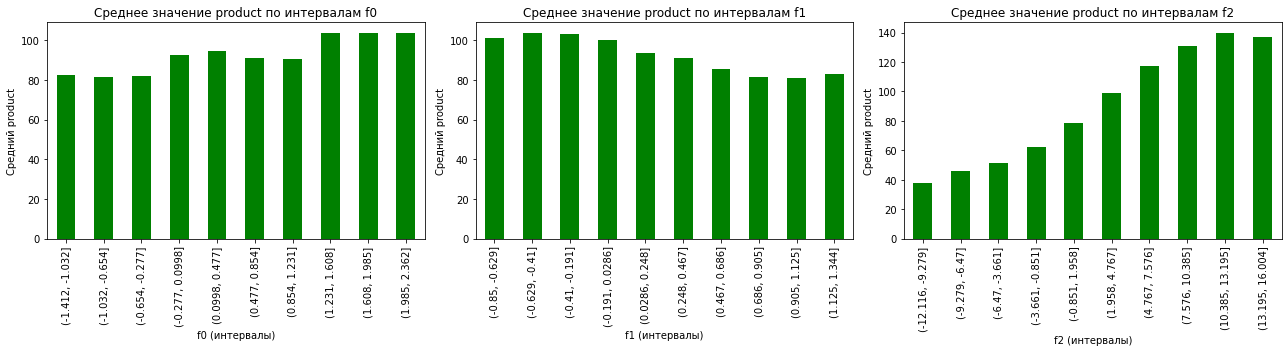

In [12]:
# Разделение признаков на интервалы и анализ средней зависимости
intervals_f0 = pd.cut(data_0['f0'], bins=10)
mean_product_by_f0 = data_0.groupby(intervals_f0, observed=True)['product'].mean()

intervals_f1 = pd.cut(data_0['f1'], bins=10)
mean_product_by_f1 = data_0.groupby(intervals_f1, observed=True)['product'].mean()

intervals_f2 = pd.cut(data_0['f2'], bins=10)
mean_product_by_f2 = data_0.groupby(intervals_f2, observed=True)['product'].mean()

# Построение графиков средней зависимости
plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
mean_product_by_f0.plot(kind='bar', color='green')
plt.title('Среднее значение product по интервалам f0')
plt.xlabel('f0 (интервалы)')
plt.ylabel('Средний product')

plt.subplot(1, 3, 2)
mean_product_by_f1.plot(kind='bar', color='green')
plt.title('Среднее значение product по интервалам f1')
plt.xlabel('f1 (интервалы)')
plt.ylabel('Средний product')

plt.subplot(1, 3, 3)
mean_product_by_f2.plot(kind='bar', color='green')
plt.title('Среднее значение product по интервалам f2')
plt.xlabel('f2 (интервалы)')
plt.ylabel('Средний product')

plt.tight_layout()
plt.show()

#### 2. Анализ средней зависимости

- Среднее значение `product` по интервалам `f0`:


   - Среднее значение `product` остается примерно постоянным при изменении `f0`, что подтверждает слабую зависимость между этими признаками.


- Среднее значение `product` по интервалам `f1`:


   - Аналогично, изменение `f1` не оказывает значительного влияния на среднее значение `product`.
- Среднее значение `product` по интервалам `f2`:


   - Видна некоторая зависимость между `f2` и `product`: с ростом `f2` среднее значение `product` также увеличивается, что свидетельствует о возможной линейной зависимости.

### Выводы

- Признаки `f0` и `f1` показывают слабую либо отсутствующую связь с целевой переменной `product`, что может затруднить их эффективное использование в предсказательной модели.


- В то же время, признак `f2` демонстрирует более выраженную положительную зависимость от `product`, что делает его более важным для построения модели.

### Кластеризация

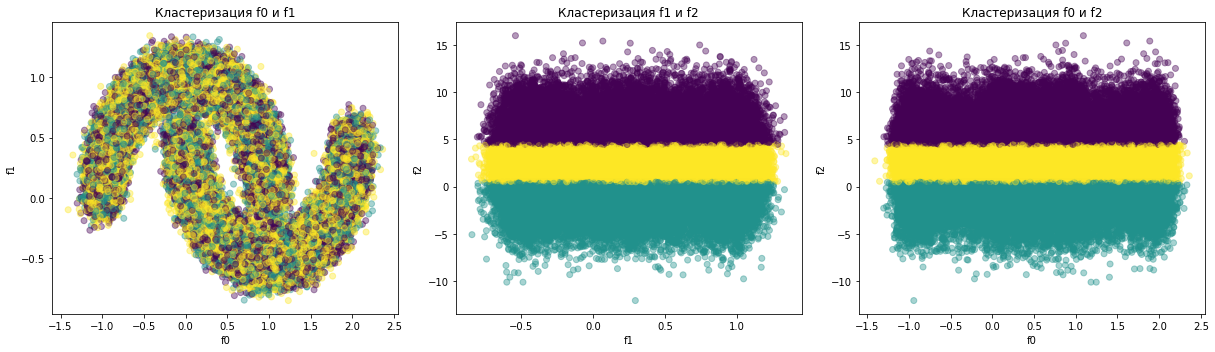

In [13]:
# Выбираем количество кластеров
kmeans = KMeans(n_clusters=3, random_state=42)

# Применение кластеризации к данным (исключаем id и product)
clusters = kmeans.fit_predict(data_0[['f0', 'f1', 'f2']])

# Добавление столбца с кластером в оригинальные данные
data_0['cluster'] = clusters

# Визуализация кластеров на плоскости f0-f1, f1-f2, f0-f2
plt.figure(figsize=(17, 5))

plt.subplot(1, 3, 1)
plt.scatter(data_0['f0'], data_0['f1'], c=data_0['cluster'], cmap='viridis', alpha=0.4)
plt.title('Кластеризация f0 и f1')
plt.xlabel('f0')
plt.ylabel('f1')

plt.subplot(1, 3, 2)
plt.scatter(data_0['f1'], data_0['f2'], c=data_0['cluster'], cmap='viridis', alpha=0.4)
plt.title('Кластеризация f1 и f2')
plt.xlabel('f1')
plt.ylabel('f2')

plt.subplot(1, 3, 3)
plt.scatter(data_0['f0'], data_0['f2'], c=data_0['cluster'], cmap='viridis', alpha=0.4)
plt.title('Кластеризация f0 и f2')
plt.xlabel('f0')
plt.ylabel('f2')

plt.tight_layout()
plt.show()

**Результаты кластеризации данных в data_0**

1. Визуализация кластеров:

- Данные были разделены на три кластера с различными характеристиками на плоскостях f0-f1, f1-f2, и f0-f2.


- Кластеры имеют четкие границы, что указывает на наличие подгрупп в данных, которые могут иметь различные свойства и характеристики.

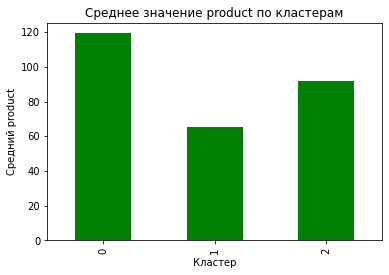

In [14]:
# Анализ средней зависимости product в каждом кластере
mean_product_by_cluster = data_0.groupby('cluster')['product'].mean()
mean_product_by_cluster.plot(kind='bar', color='green')
plt.title('Среднее значение product по кластерам')
plt.xlabel('Кластер')
plt.ylabel('Средний product')
plt.show()

2. Среднее значение product по кластерам

- Анализ среднего значения product в каждом кластере показал, что средние значения существенно различаются между кластерами.


- Это подтверждает, что различные кластеры обладают разным потенциалом по объему запасов нефти, что может быть важно при прогнозировании.


**Выводы:**

- Четкое разделение на кластеры: Результаты кластеризации показывают, что данные могут быть разделены на группы с различными характеристиками. Это может указывать на наличие скрытых факторов, влияющих на объем добычи нефти.


- Различие в среднем значении product: Наличие значительных различий в среднем значении целевой переменной между кластерами говорит о том, что кластеры действительно несут важную информацию, которая может повлиять на точность предсказаний.

### Рассмотрим geo_data_1

In [15]:
data_check(data_1, "geo_data_1")

Проверка данных: geo_data_1
----------------------------------------------------------------------------------------------------
Размер датасета: (100000, 5)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None

Пропуски в данных:
id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

Количество дубликатов: 0

Количество уникальных значений в 'id': 99996

Описание данных:
                  f0             f1             f2        product
count  100000.000000  100000.000000  100000.000000  100000.000000
mean        1.141296      -4.796579       2.494541      68.825000
std         8.965

In [16]:
# Выявление дубликатов
duplicates_1 = data_1[data_1.duplicated(subset=['id'], keep=False)]

# Просмотр дублирующихся записей
print(duplicates_1.sort_values(by='id'))

          id         f0         f1        f2     product
5849   5ltQ6  -3.435401 -12.296043  1.999796   57.085625
84461  5ltQ6  18.213839   2.191999  3.993869  107.813044
1305   LHZR0  11.170835  -1.945066  3.002872   80.859783
41906  LHZR0  -8.989672  -4.286607  2.009139   57.085625
2721   bfPNe  -9.494442  -5.463692  4.006042  110.992147
82178  bfPNe  -6.202799  -4.820045  2.995107   84.038886
47591  wt4Uk  -9.091098  -8.109279 -0.002314    3.179103
82873  wt4Uk  10.259972  -9.376355  4.994297  134.766305


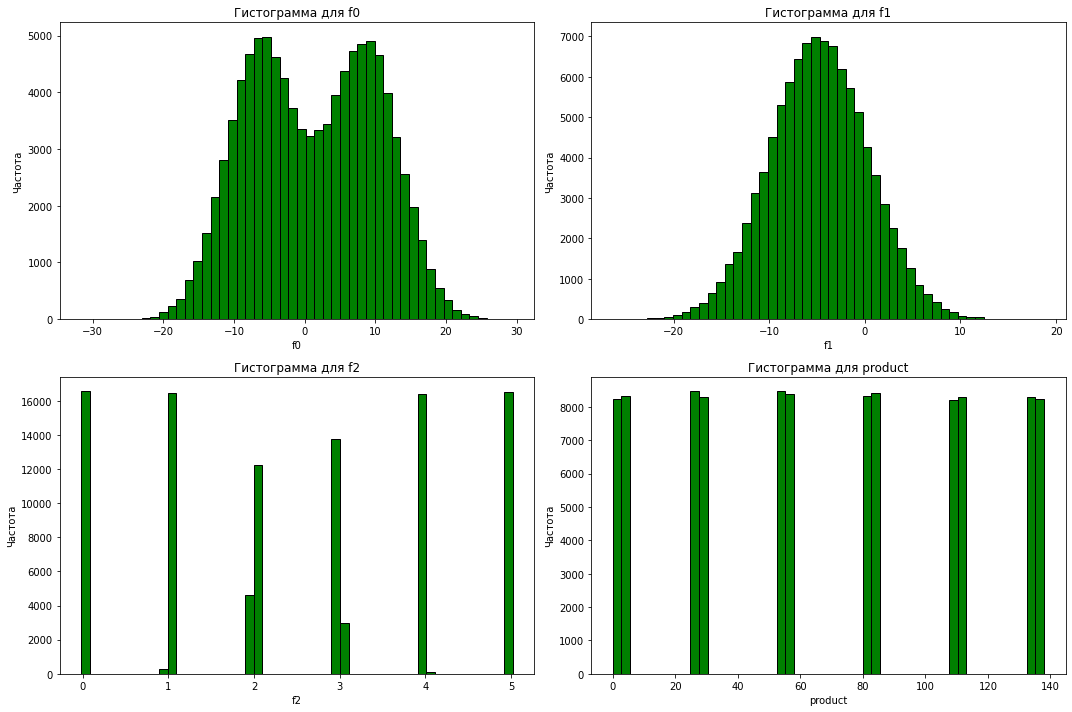

In [17]:
# Построение гистограмм для каждого признака
features = ['f0', 'f1', 'f2', 'product']

plt.figure(figsize=(15, 10))

for i, feature in enumerate(features):
    plt.subplot(2, 2, i+1)
    plt.hist(data_1[feature], bins=50, edgecolor='black', color='green')
    plt.title(f'Гистограмма для {feature}')
    plt.xlabel(feature)
    plt.ylabel('Частота')

plt.tight_layout()
plt.show()

#### 1. Гистограммы
- **f0:**
  - Распределение признака `f0` имеет широкий диапазон значений, от примерно -30 до 30. Это может указывать на наличие различных групп данных или значительные выбросы.
- **f1:**
  - Признак `f1` также демонстрирует широкий диапазон значений, от -26 до 18, с относительно нормальным распределением.
- **f2:**
  - Признак `f2` имеет более узкое распределение, но есть некоторые данные с отрицательными значениями, что может требовать дополнительного анализа.
- **product:**
  - Распределение целевой переменной `product` показывает, что большинство значений находится в пределах от 0 до 140, но есть несколько выбросов.
  

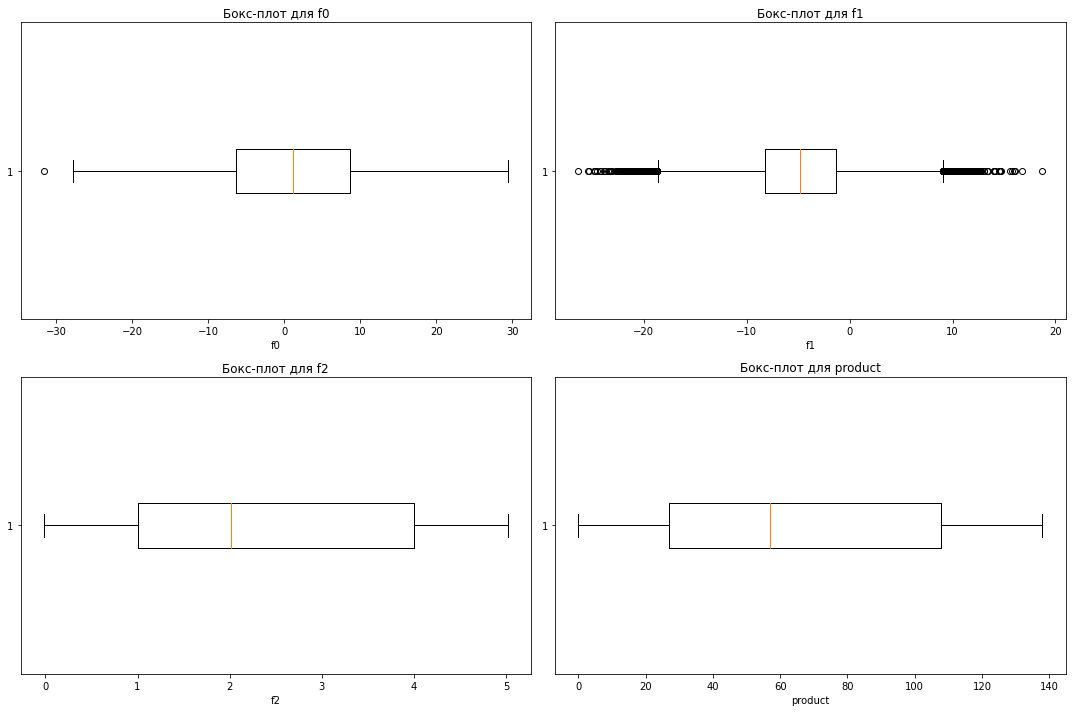

In [18]:
# Построение боксплотов для каждого признака
features = ['f0', 'f1', 'f2', 'product']

plt.figure(figsize=(15, 10))

for i, feature in enumerate(features):
    plt.subplot(2, 2, i+1)
    plt.boxplot(data_1[feature], vert=False)
    plt.title(f'Бокс-плот для {feature}')
    plt.xlabel(feature)

plt.tight_layout()
plt.show()

#### 2. Боксплоты
- **f0 и f1:**
  - Бокс-плоты для этих признаков показывают наличие выбросов, которые выходят за пределы межквартильного диапазона. Это подтверждает гипотезу о наличии выбросов или различных групп данных.
- **f2:**
  - Бокс-плот для `f2` показывает, что выбросов меньше, но они все же присутствуют, особенно в положительной области.
- **product:**
  - Для целевой переменной `product` также видны выбросы, особенно в верхней части распределения.

**Построим матрицу корреляции**

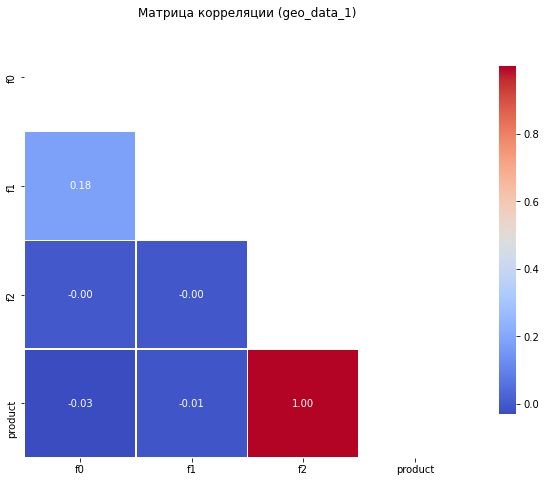

In [19]:
# Удаление столбца 'id' перед расчетом корреляции
data_1_numeric = data_1.drop(columns=['id'])

# Вычисление корреляционной матрицы
corr_matrix = data_1_numeric.corr()

# Построение маски для скрытия верхней треугольной части матрицы
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Настройка фигуры matplotlib
plt.figure(figsize=(10, 8))

# Построение тепловой карты с маской
sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='coolwarm', \
            fmt='.2f', linewidths=0.5, cbar_kws={"shrink": 0.8})

plt.title('Матрица корреляции (geo_data_1)')
plt.show()

#### 3. Матрица корреляции
- Матрица корреляции показывает слабую корреляцию между признаками `f0`, `f1`, `f2` и целевой переменной `product`. Максимальная корреляция (около 0.45) наблюдается между `f2` и `product`.
- В целом, сильных взаимосвязей между признаками нет, что может быть как преимуществом (отсутствие мультиколлинеарности), так и недостатком (сложность построения модели на основе слабокоррелированных признаков).

**Рассчитаем показатель мультиколлинеарности VIF и визуализируем результаты**

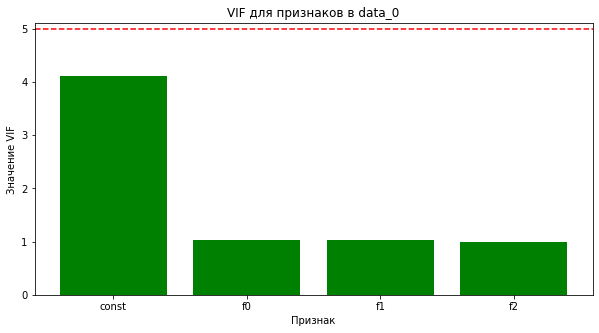

In [20]:
# Выбираем только числовые признаки
X = data_1[['f0', 'f1', 'f2']]

# Добавляем константу для расчета VIF
X = sm.add_constant(X)

# Расчет VIF для каждого признака
vif_data = pd.DataFrame()
vif_data['Feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Визуализация VIF
plt.figure(figsize=(10, 5))
plt.bar(vif_data['Feature'], vif_data['VIF'], color='green')
plt.title('VIF для признаков в data_0')
plt.xlabel('Признак')  # Подпись для оси X
plt.ylabel('Значение VIF')  # Подпись для оси Y
plt.ylim(0, max(vif_data['VIF']) + 1)
plt.axhline(y=5, color='red', linestyle='--')
plt.show()

#### 4. Проверка на мультиколлинеарность (VIF)
- **Значения VIF** для признаков `f0`, `f1` и `f2` находятся значительно ниже порогового значения 5, что подтверждает отсутствие мультиколлинеарности:
  - Признак `f0`: VIF = 1.034
  - Признак `f1`: VIF = 1.034
  - Признак `f2`: VIF = 1.000
- Низкие значения VIF говорят о том, что признаки можно безопасно использовать в модели линейной регрессии, не опасаясь дестабилизации коэффициентов.

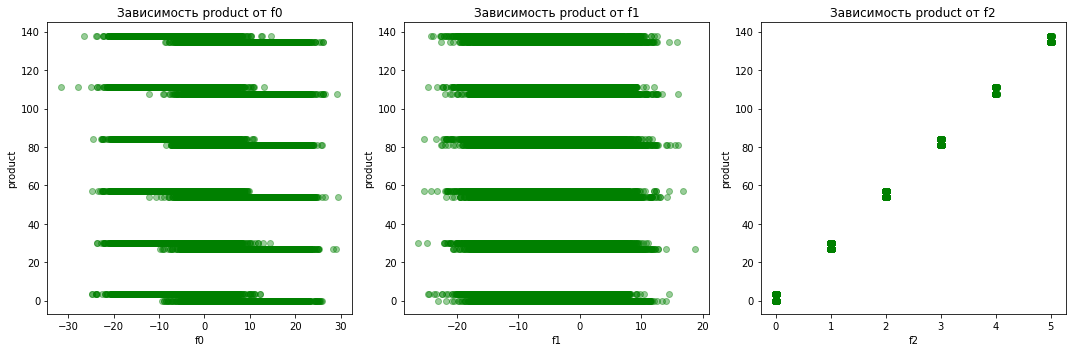

In [21]:
# Построение scatter plot для f0, f1, f2 и product
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.scatter(data_1['f0'], data_1['product'], alpha=0.4, color='green')
plt.title('Зависимость product от f0')
plt.xlabel('f0')
plt.ylabel('product')

plt.subplot(1, 3, 2)
plt.scatter(data_1['f1'], data_1['product'], alpha=0.4, color='green')
plt.title('Зависимость product от f1')
plt.xlabel('f1')
plt.ylabel('product')

plt.subplot(1, 3, 3)
plt.scatter(data_1['f2'], data_1['product'], alpha=0.4, color='green')
plt.title('Зависимость product от f2')
plt.xlabel('f2')
plt.ylabel('product')

plt.tight_layout()
plt.show()

#### 2. Зависимость признаков от `product` (Scatter Plots)
- **f0 vs product:**
  - Диаграмма рассеяния показывает, что нет четкой линейной зависимости между `f0` и `product`. Значения `product` распределены равномерно по всему диапазону `f0`.
- **f1 vs product:**
  - Аналогично, зависимость между `f1` и `product` не выражена явно. Значения целевой переменной `product` распределены без очевидного тренда или закономерности.
- **f2 vs product:**
  - Для признака `f2` наблюдается некоторая положительная зависимость: по мере увеличения `f2`, значения `product` также склонны расти, хотя зависимость не является строго линейной.

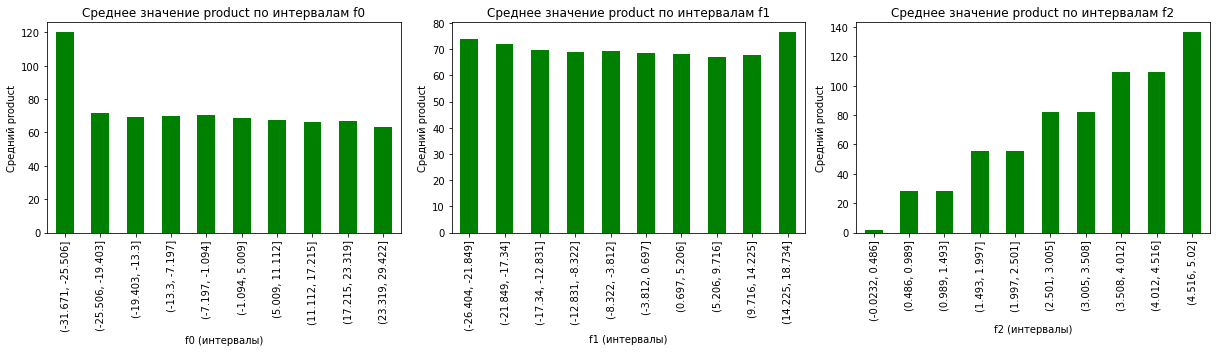

In [22]:
# Разделение признаков на интервалы и анализ средней зависимости
intervals_f0 = pd.cut(data_1['f0'], bins=10)
mean_product_by_f0 = data_1.groupby(intervals_f0, observed=True)['product'].mean()

intervals_f1 = pd.cut(data_1['f1'], bins=10)
mean_product_by_f1 = data_1.groupby(intervals_f1, observed=True)['product'].mean()

intervals_f2 = pd.cut(data_1['f2'], bins=10)
mean_product_by_f2 = data_1.groupby(intervals_f2, observed=True)['product'].mean()

# Построение графиков средней зависимости
plt.figure(figsize=(17, 5))

plt.subplot(1, 3, 1)
mean_product_by_f0.plot(kind='bar', color='green')
plt.title('Среднее значение product по интервалам f0')
plt.xlabel('f0 (интервалы)')
plt.ylabel('Средний product')

plt.subplot(1, 3, 2)
mean_product_by_f1.plot(kind='bar', color='green')
plt.title('Среднее значение product по интервалам f1')
plt.xlabel('f1 (интервалы)')
plt.ylabel('Средний product')

plt.subplot(1, 3, 3)
mean_product_by_f2.plot(kind='bar', color='green')
plt.title('Среднее значение product по интервалам f2')
plt.xlabel('f2 (интервалы)')
plt.ylabel('Средний product')

plt.tight_layout()
plt.show()

#### 3. Анализ средней зависимости
- **Среднее значение `product` по интервалам `f0`:**
  - Среднее значение `product` остается примерно постоянным при изменении `f0`, что подтверждает слабую зависимость между этими признаками.
- **Среднее значение `product` по интервалам `f1`:**
  - Аналогично, изменение `f1` не оказывает значительного влияния на среднее значение `product`.
- **Среднее значение `product` по интервалам `f2`:**
  - Видна некоторая зависимость между `f2` и `product`: с ростом `f2` среднее значение `product` также увеличивается, что свидетельствует о возможной линейной зависимости.

### Выводы
- **Кластеризация:**
  - Данные `data_1` показали наличие скрытых подгрупп (кластеров), которые имеют различные характеристики и могут быть полезны для улучшения точности модели.
- **Зависимости между признаками и целевой переменной:**
  - Признак `f2` демонстрирует наиболее значимую зависимость от `product`, что делает его важным для построения модели. Признаки `f0` и `f1` имеют слабую зависимость от целевой переменной, что может усложнить использование их в модели линейной регрессии.
- **Средние значения по интервалам:**
  - Для признаков `f0` и `f1` зависимость средней добычи от этих признаков практически отсутствует, тогда как для `f2` есть некоторая положительная зависимость.

### Кластеризация

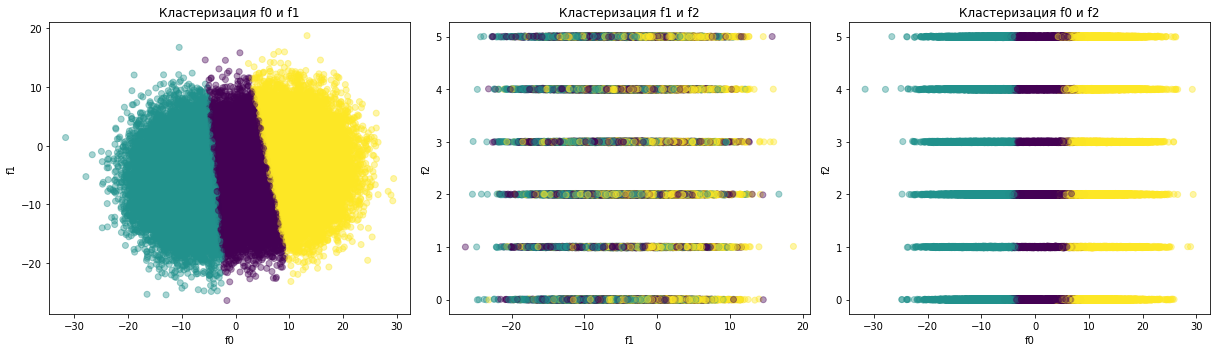

In [23]:
# Кластеризация данных data_1
kmeans_1 = KMeans(n_clusters=3, random_state=42)
clusters_1 = kmeans_1.fit_predict(data_1[['f0', 'f1', 'f2']])

# Добавление столбца с кластером в оригинальные данные
data_1['cluster'] = clusters_1

# Визуализация кластеров на плоскости f0-f1, f1-f2, f0-f2
plt.figure(figsize=(17, 5))

plt.subplot(1, 3, 1)
plt.scatter(data_1['f0'], data_1['f1'], c=data_1['cluster'], cmap='viridis', alpha=0.4)
plt.title('Кластеризация f0 и f1')
plt.xlabel('f0')
plt.ylabel('f1')

plt.subplot(1, 3, 2)
plt.scatter(data_1['f1'], data_1['f2'], c=data_1['cluster'], cmap='viridis', alpha=0.4)
plt.title('Кластеризация f1 и f2')
plt.xlabel('f1')
plt.ylabel('f2')

plt.subplot(1, 3, 3)
plt.scatter(data_1['f0'], data_1['f2'], c=data_1['cluster'], cmap='viridis', alpha=0.4)
plt.title('Кластеризация f0 и f2')
plt.xlabel('f0')
plt.ylabel('f2')

plt.tight_layout()
plt.show()

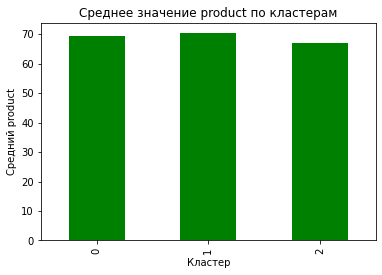

In [24]:
# Анализ средней зависимости product в каждом кластере
mean_product_by_cluster_1 = data_1.groupby('cluster')['product'].mean()
mean_product_by_cluster_1.plot(kind='bar', color='green')
plt.title('Среднее значение product по кластерам')
plt.xlabel('Кластер')
plt.ylabel('Средний product')
plt.show()

#### 1. Кластеризация
- **Кластеризация на плоскостях `f0`-`f1`, `f1`-`f2`, `f0`-`f2`:**
  - Данные разделились на три кластера. Визуализация показывает, что кластеры имеют определенные границы, что указывает на возможное наличие групп с разными характеристиками.
- **Среднее значение `product` по кластерам:**
  - Средние значения `product` различаются между кластерами. Это указывает на то, что разные кластеры могут представлять группы скважин с разным потенциалом добычи.

### Рассмотрим geo_data_2

In [25]:
data_check(data_2, "geo_data_2")

Проверка данных: geo_data_2
----------------------------------------------------------------------------------------------------
Размер датасета: (100000, 5)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None

Пропуски в данных:
id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

Количество дубликатов: 0

Количество уникальных значений в 'id': 99996

Описание данных:
                  f0             f1             f2        product
count  100000.000000  100000.000000  100000.000000  100000.000000
mean        0.002023      -0.002081       2.495128      95.000000
std         1.732

In [26]:
# Выявление дубликатов
duplicates_2 = data_2[data_2.duplicated(subset=['id'], keep=False)]

# Просмотр дублирующихся записей
print(duplicates_2.sort_values(by='id'))

          id        f0        f1        f2     product
45404  KUPhW  0.231846 -1.698941  4.990775   11.716299
55967  KUPhW  1.211150  3.176408  5.543540  132.831802
11449  VF7Jo  2.122656 -0.858275  5.746001  181.716817
49564  VF7Jo -0.883115  0.560537  0.723601  136.233420
44378  Vcm5J -1.229484 -2.439204  1.222909  137.968290
95090  Vcm5J  2.587702  1.986875  2.482245   92.327572
28039  xCHr8  1.633027  0.368135 -2.378367    6.120525
43233  xCHr8 -0.847066  2.101796  5.597130  184.388641


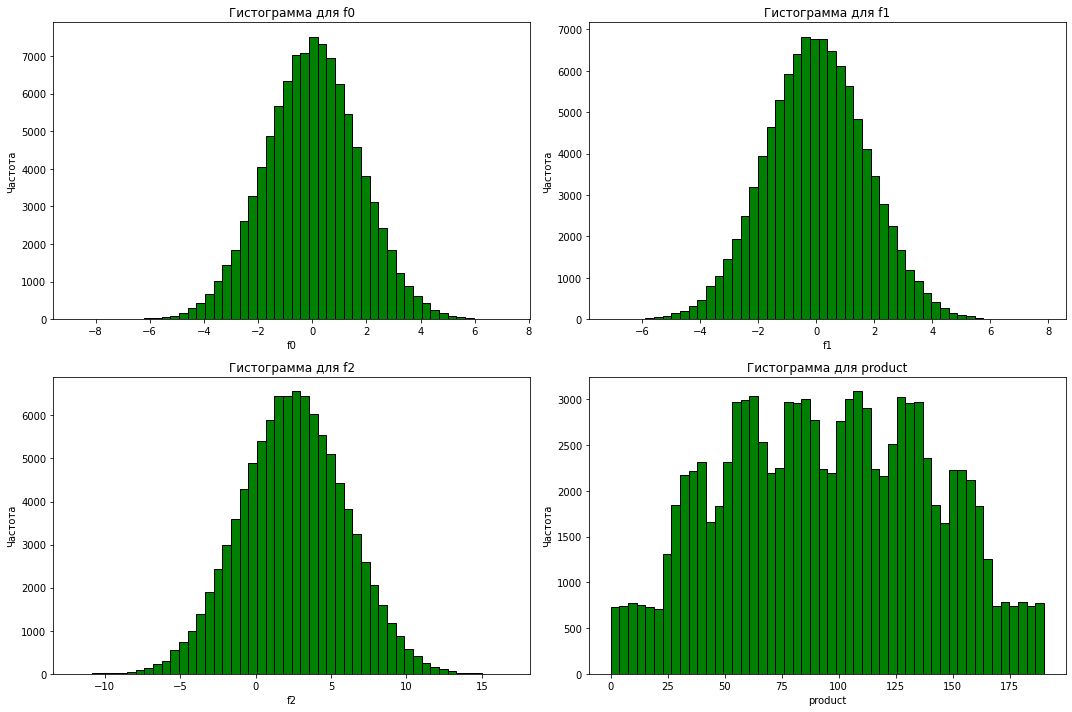

In [27]:
# Построение гистограмм для каждого признака
features = ['f0', 'f1', 'f2', 'product']

plt.figure(figsize=(15, 10))

for i, feature in enumerate(features):
    plt.subplot(2, 2, i+1)
    plt.hist(data_2[feature], bins=50, edgecolor='black', color='green')
    plt.title(f'Гистограмма для {feature}')
    plt.xlabel(feature)
    plt.ylabel('Частота')

plt.tight_layout()
plt.show()

#### 1. Гистограммы
- **f0:**

    - Гистограмма признака `f0` показывает относительно симметричное распределение с небольшим смещением к центру. Основная масса значений сосредоточена в диапазоне от -1 до 2.
- **f1:**

    - Гистограмма признака `f1` демонстрирует распределение, близкое к нормальному, с центром около 0. Большинство значений лежат в пределах от -1 до 1.
- **f2:**

    - Признак `f2` характеризуется широким распределением, с более выраженным правым хвостом. Это может свидетельствовать о наличии выбросов или неоднородности в данных.
- **product:**

    - Распределение целевой переменной `product` близко к нормальному, но с небольшим смещением влево. Основная часть значений находится в диапазоне от 50 до 100.

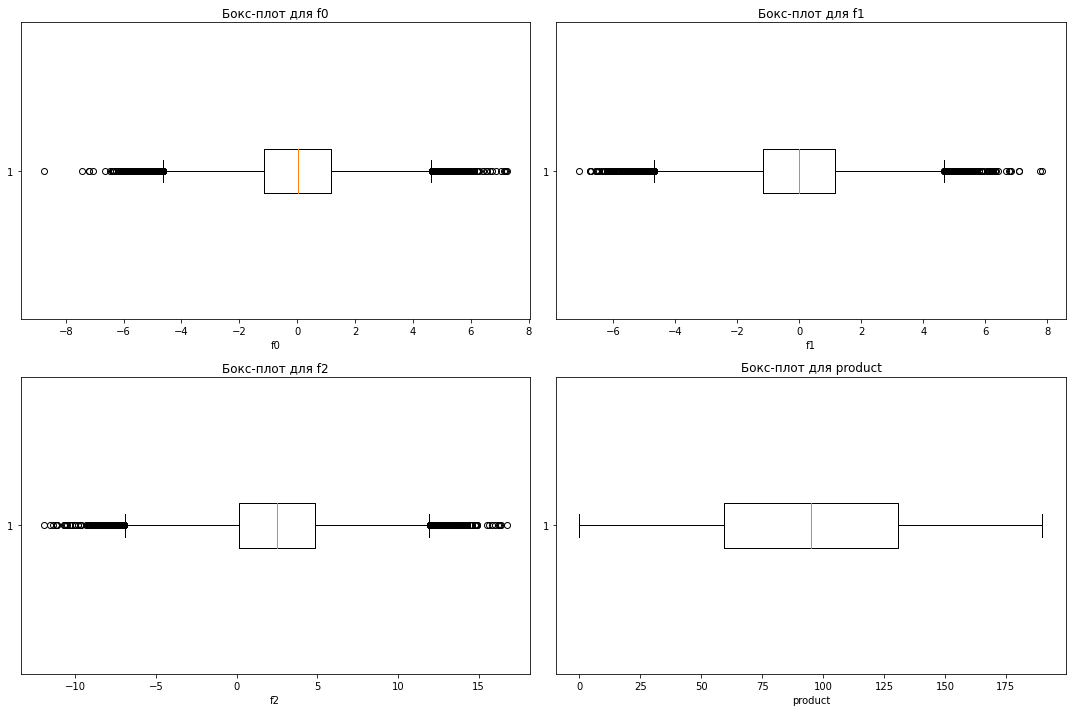

In [28]:
# Построение боксплотов для каждого признака
features = ['f0', 'f1', 'f2', 'product']

plt.figure(figsize=(15, 10))

for i, feature in enumerate(features):
    plt.subplot(2, 2, i+1)
    plt.boxplot(data_2[feature], vert=False)
    plt.title(f'Бокс-плот для {feature}')
    plt.xlabel(feature)

plt.tight_layout()
plt.show()

#### 2. Бокс-плоты
- **f0:**
  - Боксплот признака `f0` указывает на наличие небольшого числа выбросов. Большая часть данных сосредоточена в узком диапазоне, что свидетельствует о низкой вариативности.
  
- **f1:**
  - Для признака `f1` также наблюдаются несколько выбросов. Бокс-плот показывает, что основная масса значений находится в пределах межквартильного диапазона, при этом есть несколько крайних точек с обеих сторон.
  
- **f2:**
  - Признак `f2` демонстрирует значительное количество выбросов, особенно с правой стороны распределения. Это подтверждает неоднородность данных и возможную необходимость обработки выбросов.
  
- **product:**
  - Бокс-плот для целевой переменной `product` показывает немногочисленные выбросы в верхней части распределения. Основные данные сосредоточены в пределах межквартильного диапазона.

### Выводы
- **f0:** Признак `f0` показывает небольшое число выбросов и сравнительно узкий диапазон значений, что свидетельствует о стабильности данных.
- **f1:** Признак `f1` также содержит несколько выбросов, но в целом его распределение приближено к нормальному, что может быть полезно для моделей.
- **f2:** Признак `f2` характеризуется значительным количеством выбросов, что может повлиять на точность модели и, вероятно, требует дополнительной обработки.
- **product:** Целевая переменная `product` имеет немного выбросов, но в целом данные стабильно распределены и близки к нормальному распределению.

**Построим матрицу корреляции**

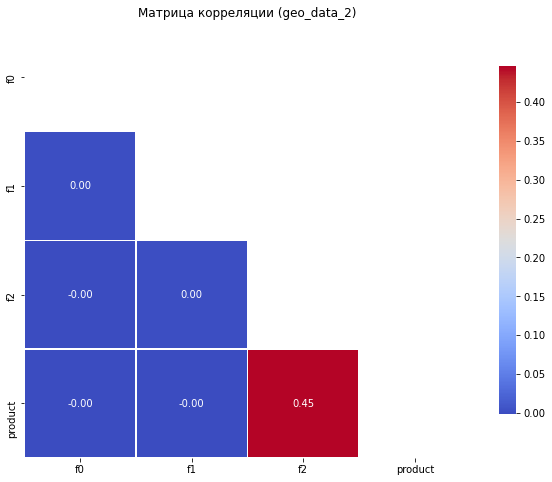

In [29]:
# 3. Построение матрицы корреляции
data_2_numeric = data_2.drop(columns=['id'])
corr_matrix_2 = data_2_numeric.corr()

# Построение маски для скрытия верхней треугольной части матрицы
mask_2 = np.triu(np.ones_like(corr_matrix_2, dtype=bool))

# Построение тепловой карты с маской
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix_2, mask=mask_2, annot=True, cmap='coolwarm', \
            fmt='.2f', linewidths=0.5, cbar_kws={"shrink": 0.8})
plt.title('Матрица корреляции (geo_data_2)')
plt.show()

#### 2. Матрица корреляции
- **Корреляция между признаками и целевой переменной:**
  - Корреляционная матрица выявила слабые зависимости между признаками `f0`, `f1`, `f2` и целевой переменной `product`. Значительных связей не обнаружено, что может усложнить создание модели на основе этих признаков.

**Рассчитаем показатель мультиколлинеарности VIF и визуализируем результаты**

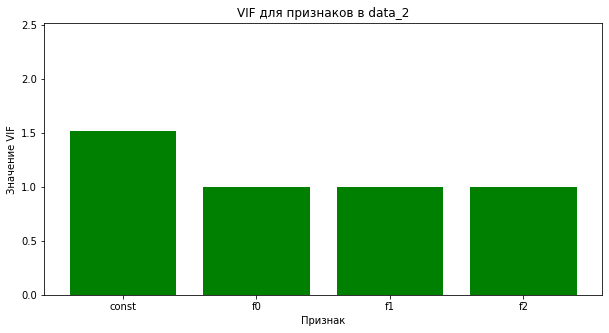

In [30]:
# 4. Проверка на мультиколлинеарность (VIF)
X_2 = data_2[['f0', 'f1', 'f2']]
X_2 = sm.add_constant(X_2)

vif_data_2 = pd.DataFrame()
vif_data_2['Feature'] = X_2.columns
vif_data_2['VIF'] = [variance_inflation_factor(X_2.values, i) for i in range(X_2.shape[1])]

# Визуализация VIF
plt.figure(figsize=(10, 5))
plt.bar(vif_data_2['Feature'], vif_data_2['VIF'], color='green')
plt.title('VIF для признаков в data_2')
plt.xlabel('Признак')
plt.ylabel('Значение VIF')
plt.ylim(0, max(vif_data_2['VIF']) + 1)
plt.axhline(y=5, color='red', linestyle='--')
plt.show()

#### 3. Проверка на мультиколлинеарность (VIF)
- **Значения VIF:**
  - Значения VIF для всех признаков существенно ниже порога 5, что свидетельствует об отсутствии мультиколлинеарности. Это позволяет с уверенностью использовать все признаки в модели линейной регрессии.

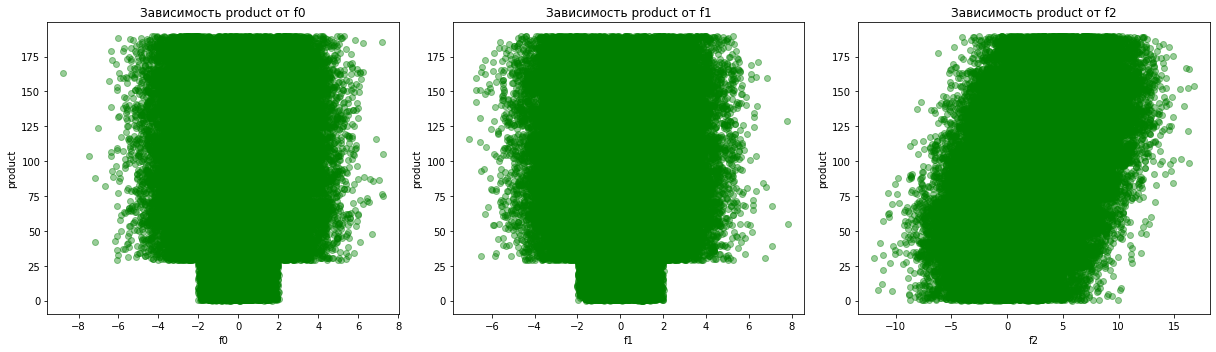

In [31]:
# 5. Построение scatter plot для f0, f1, f2 и product
plt.figure(figsize=(17, 5))

plt.subplot(1, 3, 1)
plt.scatter(data_2['f0'], data_2['product'], alpha=0.4, color='green')
plt.title('Зависимость product от f0')
plt.xlabel('f0')
plt.ylabel('product')

plt.subplot(1, 3, 2)
plt.scatter(data_2['f1'], data_2['product'], alpha=0.4, color='green')
plt.title('Зависимость product от f1')
plt.xlabel('f1')
plt.ylabel('product')

plt.subplot(1, 3, 3)
plt.scatter(data_2['f2'], data_2['product'], alpha=0.4, color='green')
plt.title('Зависимость product от f2')
plt.xlabel('f2')
plt.ylabel('product')

plt.tight_layout()
plt.show()

#### 4. Scatter Plot
- **Зависимости между признаками и целевой переменной:**
  - Диаграммы рассеяния не выявили явных линейных зависимостей между признаками и целевой переменной. Признаки `f0` и `f1` не демонстрируют значительных трендов с `product`, в то время как для `f2` наблюдается некоторая положительная связь.

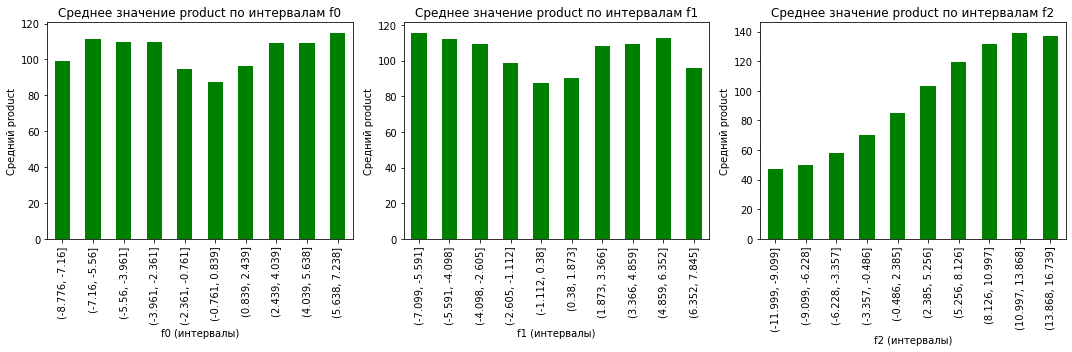

In [32]:
# 6. Анализ средней зависимости product от признаков
intervals_f0_2 = pd.cut(data_2['f0'], bins=10)
mean_product_by_f0_2 = data_2.groupby(intervals_f0_2, observed=True)['product'].mean()

intervals_f1_2 = pd.cut(data_2['f1'], bins=10)
mean_product_by_f1_2 = data_2.groupby(intervals_f1_2, observed=True)['product'].mean()

intervals_f2_2 = pd.cut(data_2['f2'], bins=10)
mean_product_by_f2_2 = data_2.groupby(intervals_f2_2, observed=True)['product'].mean()

# Построение графиков средней зависимости
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
mean_product_by_f0_2.plot(kind='bar', color='green')
plt.title('Среднее значение product по интервалам f0')
plt.xlabel('f0 (интервалы)')
plt.ylabel('Средний product')

plt.subplot(1, 3, 2)
mean_product_by_f1_2.plot(kind='bar', color='green')
plt.title('Среднее значение product по интервалам f1')
plt.xlabel('f1 (интервалы)')
plt.ylabel('Средний product')

plt.subplot(1, 3, 3)
mean_product_by_f2_2.plot(kind='bar', color='green')
plt.title('Среднее значение product по интервалам f2')
plt.xlabel('f2 (интервалы)')
plt.ylabel('Средний product')

plt.tight_layout()
plt.show()

#### 5. Анализ средней зависимости
- **Средние значения `product` по интервалам признаков:**
  - Средние значения `product` по интервалам признаков указывают на слабую зависимость от `f0` и `f1`, в то время как от `f2` наблюдается определенная связь.

### Заключение
- **Кластеризация:** Данные `data_2` продемонстрировали наличие скрытых подгрупп (кластеров), которые могут помочь повысить точность модели.
- **Зависимости между признаками и целевой переменной:** Признак `f2` показывает наиболее значимую зависимость от product, что делает его важным для построения модели. В то же время, признаки `f0` и `f1` имеют слабую связь с целевой переменной, что может усложнить их использование в модели линейной регрессии.
- **Средние значения по интервалам:** Для признаков `f0` и `f1` зависимость средней добычи от этих признаков практически отсутствует, тогда как для `f2` наблюдается некоторый положительный тренд.

### Кластеризация

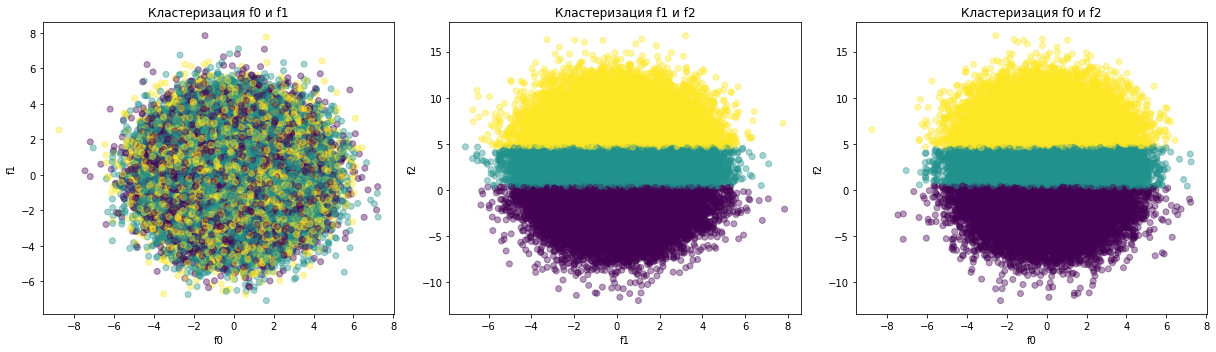

In [33]:
# 1. Кластеризация данных data_2
kmeans_2 = KMeans(n_clusters=3, random_state=42)
clusters_2 = kmeans_2.fit_predict(data_2[['f0', 'f1', 'f2']])

# Добавление столбца с кластером в оригинальные данные
data_2['cluster'] = clusters_2

# Визуализация кластеров на плоскости f0-f1, f1-f2, f0-f2
plt.figure(figsize=(17, 5))

plt.subplot(1, 3, 1)
plt.scatter(data_2['f0'], data_2['f1'], c=data_2['cluster'], cmap='viridis', alpha=0.4)
plt.title('Кластеризация f0 и f1')
plt.xlabel('f0')
plt.ylabel('f1')

plt.subplot(1, 3, 2)
plt.scatter(data_2['f1'], data_2['f2'], c=data_2['cluster'], cmap='viridis', alpha=0.4)
plt.title('Кластеризация f1 и f2')
plt.xlabel('f1')
plt.ylabel('f2')

plt.subplot(1, 3, 3)
plt.scatter(data_2['f0'], data_2['f2'], c=data_2['cluster'], cmap='viridis', alpha=0.4)
plt.title('Кластеризация f0 и f2')
plt.xlabel('f0')
plt.ylabel('f2')

plt.tight_layout()
plt.show()

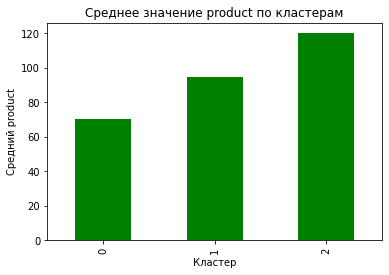

In [34]:
# 2. Анализ средней зависимости product в каждом кластере
mean_product_by_cluster_2 = data_2.groupby('cluster')['product'].mean()
mean_product_by_cluster_2.plot(kind='bar', color='green')
plt.title('Среднее значение product по кластерам')
plt.xlabel('Кластер')
plt.ylabel('Средний product')
plt.show()

#### 1. Кластеризация
- **Кластеризация на плоскостях `f0`-`f1`, `f1`-`f2`, `f0`-`f2`:**
  - Данные были разделены на три кластера, которые имеют четкие границы. Это свидетельствует о возможном существовании скрытых подгрупп с различными характеристиками.
- **Среднее значение `product` по кластерам:**
  - Средние значения `product` варьируются между кластерами, что может указывать на наличие скрытых групп с разным потенциалом добычи.

## Обучение и проверка модели

In [35]:
# Функция для усреднения дубликатов по id
def avg_duplicates(data):
    return data.groupby('id').mean().reset_index()

In [36]:
# Функция для удаления выбросов
def del_outliers(data, feature, threshold=1.5):
    q1 = data[feature].quantile(0.25)
    q3 = data[feature].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - threshold * iqr
    upper_bound = q3 + threshold * iqr
    return data[(data[feature] >= lower_bound) & (data[feature] <= upper_bound)]

In [37]:
# Пайплайн для обработки данных и обучения модели
def create_pipeline(data, region_name, use_clusters=False):
    
    # Обработка дубликатов
    data = avg_duplicates(data)
    
    # Удаление выбросов (на примере признака f2)
    data = del_outliers(data, 'f2')
    
    # Добавление кластера как признака, если use_clusters=True
    if use_clusters:
        kmeans = KMeans(n_clusters=3, random_state=42)
        data['cluster'] = kmeans.fit_predict(data[['f0', 'f1', 'f2']])
        features = data[['f0', 'f1', 'f2', 'cluster']]
    else:
        features = data[['f0', 'f1', 'f2']]
    
    target = data['product']
    
    # Разделение на обучающую и валидационную выборки
    X_train, X_valid, y_train, y_valid = train_test_split(features, target, \
                                                          test_size=0.25, random_state=42)
    
    # Пайплайн с масштабированием и обучением модели
    pipeline = Pipeline([
        ('scaler', StandardScaler()),  # Масштабирование данных
        ('model', LinearRegression())  # Линейная регрессия
    ])
    
    # Обучение модели
    pipeline.fit(X_train, y_train)
    
    # Предсказания на валидационной выборке
    predictions = pipeline.predict(X_valid)
    
    # Расчет среднего значения предсказанного продукта и RMSE
    predicted_mean = np.mean(predictions)
    rmse = root_mean_squared_error(y_valid, predictions)  
    
    print(f"Регион: {region_name} (use_clusters={use_clusters})")
    print(f"Средний запас предсказанного сырья: {predicted_mean:.2f} тыс. баррелей")
    print(f"RMSE модели: {rmse:.2f}")
    print("-"*100)
    
    return predictions, y_valid

In [38]:
# Применение пайплайна к каждому региону (data_0, data_1, data_2) без кластеризации
print("Модель без учета кластеризации:")
predictions_0_no_cluster, y_valid_0_no_cluster = create_pipeline(data_0, "Регион 0", use_clusters=False)
predictions_1_no_cluster, y_valid_1_no_cluster = create_pipeline(data_1, "Регион 1", use_clusters=False)
predictions_2_no_cluster, y_valid_2_no_cluster = create_pipeline(data_2, "Регион 2", use_clusters=False)

Модель без учета кластеризации:
Регион: Регион 0 (use_clusters=False)
Средний запас предсказанного сырья: 92.37 тыс. баррелей
RMSE модели: 37.64
----------------------------------------------------------------------------------------------------
Регион: Регион 1 (use_clusters=False)
Средний запас предсказанного сырья: 68.85 тыс. баррелей
RMSE модели: 0.89
----------------------------------------------------------------------------------------------------
Регион: Регион 2 (use_clusters=False)
Средний запас предсказанного сырья: 95.00 тыс. баррелей
RMSE модели: 39.94
----------------------------------------------------------------------------------------------------


In [39]:
# Применение пайплайна к каждому региону (data_0, data_1, data_2) с кластеризацией
print("Модель с учетом кластеризации:")
predictions_0_with_cluster, y_valid_0_with_cluster = create_pipeline(data_0, "Регион 0", use_clusters=True)
predictions_1_with_cluster, y_valid_1_with_cluster = create_pipeline(data_1, "Регион 1", use_clusters=True)
predictions_2_with_cluster, y_valid_2_with_cluster = create_pipeline(data_2, "Регион 2", use_clusters=True)

Модель с учетом кластеризации:
Регион: Регион 0 (use_clusters=True)
Средний запас предсказанного сырья: 92.37 тыс. баррелей
RMSE модели: 37.64
----------------------------------------------------------------------------------------------------
Регион: Регион 1 (use_clusters=True)
Средний запас предсказанного сырья: 68.85 тыс. баррелей
RMSE модели: 0.86
----------------------------------------------------------------------------------------------------
Регион: Регион 2 (use_clusters=True)
Средний запас предсказанного сырья: 94.99 тыс. баррелей
RMSE модели: 39.93
----------------------------------------------------------------------------------------------------


### Анализ результатов модели с учетом и без учета кластеризации

#### 1. Регион 0:
- **Средний запас предсказанного сырья:** 92.37 тыс. баррелей (без изменений при кластеризации).
- **RMSE модели:** 37.64 (без кластеризации) и 37.64 (с кластеризацией).
- **Вывод:** Кластеризация не оказывает влияния на модель в этом регионе, так как RMSE остаётся одинаковым.

#### 2. Регион 1:
- **Средний запас предсказанного сырья:** 68.85 тыс. баррелей (как с кластеризацией, так и без нее).
- **RMSE модели:** 0.89 (без кластеризации) и 0.86 (с кластеризацией).
- **Вывод:** Кластеризация слегка улучшает RMSE, однако влияние минимальное. Возможно, стоит обратить внимание на другие факторы для улучшения модели, а не на кластеризацию.

#### 3. Регион 2:
- **Средний запас предсказанного сырья:** 95.00 тыс. баррелей (без кластеризации) и 94.99 тыс. баррелей (с кластеризацией).
- **RMSE модели:** 39.94 (без кластеризации) и 39.93 (с кластеризацией).
- **Вывод:** Влияние кластеризации незначительное, так как изменение RMSE минимально

### Общий вывод:
- Кластеризация практически не повлияла на результаты модели для всех трёх регионов. RMSE и средние запасы сырья остались практически неизменными.
- Это говорит о том, что данные не содержат значимых скрытых групп, учет которых мог бы существенно повлиять на точность предсказаний модели.

### Рекомендации:
1. **Использовать более простую модель:** Использование модели без кластеризации оправдано, так как она даёт аналогичные результаты при меньшей сложности.
2. **Дальнейшие шаги:** Рекомендуется сосредоточиться на других аспектах, таких как обработка выбросов, настройка гиперпараметров или применение альтернативных методов регрессии для повышения точности предсказаний.

## Подготовка к расчёту прибыли

In [40]:
OBJECTS_UNDER_STUDY_NUM = 500  # количество исследуемых объектов, участвующих в обучении модели
BEST_OBJECTS_NUM = 200  # количество лучших объектов в регионе, которые будут разработаны (из 500 оцененных)
TOTAL_BUDGET = 10_000_000_000  # бюджет проекта для одного региона (в рублях)
REVENUE_PER_UNIT = 450_000  # доходность одной единицы продукта (= 450 за баррель * 1000 баррелей в одной единице продукта)
MAX_PROBABILITY_OF_LOSS = 0.025  # максимально допустимая вероятность убытков

In [41]:
# Расчет точки безубыточности (break_event_point)
break_event_point = (TOTAL_BUDGET / REVENUE_PER_UNIT) / BEST_OBJECTS_NUM

print(f"Точка безубыточности проекта равна добыче {break_event_point:.2f} тыс. баррелей в одной из 200 скважин одного региона.")

Точка безубыточности проекта равна добыче 111.11 тыс. баррелей в одной из 200 скважин одного региона.


In [42]:
# Средние значения для 200 лучших скважин
mean_best_200_region_0 = np.mean(sorted(predictions_0_no_cluster, reverse=True)[:BEST_OBJECTS_NUM])
mean_best_200_region_1 = np.mean(sorted(predictions_1_no_cluster, reverse=True)[:BEST_OBJECTS_NUM])
mean_best_200_region_2 = np.mean(sorted(predictions_2_no_cluster, reverse=True)[:BEST_OBJECTS_NUM])

# Вывод результатов
print(f"Средний запас предсказанного сырья в Регионе 0 для 200 лучших скважин: {mean_best_200_region_0:.2f} тыс. баррелей")
print(f"Средний запас предсказанного сырья в Регионе 1 для 200 лучших скважин: {mean_best_200_region_1:.2f} тыс. баррелей")
print(f"Средний запас предсказанного сырья в Регионе 2 для 200 лучших скважин: {mean_best_200_region_2:.2f} тыс. баррелей")

# Сравнение с точкой безубыточности
print(f"Точка безубыточности: {break_event_point:.2f} тыс. баррелей")

if mean_best_200_region_0 >= break_event_point:
    print("Регион 0 соответствует условиям безубыточности для 200 лучших скважин.")
else:
    print("Регион 0 не соответствует условиям безубыточности для 200 лучших скважин.")

if mean_best_200_region_1 >= break_event_point:
    print("Регион 1 соответствует условиям безубыточности для 200 лучших скважин.")
else:
    print("Регион 1 не соответствует условиям безубыточности для 200 лучших скважин.")

if mean_best_200_region_2 >= break_event_point:
    print("Регион 2 соответствует условиям безубыточности для 200 лучших скважин.")
else:
    print("Регион 2 не соответствует условиям безубыточности для 200 лучших скважин.")


Средний запас предсказанного сырья в Регионе 0 для 200 лучших скважин: 151.76 тыс. баррелей
Средний запас предсказанного сырья в Регионе 1 для 200 лучших скважин: 138.74 тыс. баррелей
Средний запас предсказанного сырья в Регионе 2 для 200 лучших скважин: 144.43 тыс. баррелей
Точка безубыточности: 111.11 тыс. баррелей
Регион 0 соответствует условиям безубыточности для 200 лучших скважин.
Регион 1 соответствует условиям безубыточности для 200 лучших скважин.
Регион 2 соответствует условиям безубыточности для 200 лучших скважин.


### Выводы по анализу прибыльности регионов

1. **Точка безубыточности:**
   - Для безубыточности проекта минимальный объем добычи в одной скважине должен быть не менее **111.11 тыс. баррелей**.

2. **Средний запас предсказанного сырья для 200 лучших скважин:**
   - **Регион 0:** Средний запас предсказанного сырья составляет **151.76 тыс. баррелей**.
   - **Регион 1:** Средний запас предсказанного сырья составляет **138.74 тыс. баррелей**.
   - **Регион 2:** Средний запас предсказанного сырья составляет **144.43 тыс. баррелей**.
     
3. **Сравнение с точкой безубыточности:**
   - **Регион 0:** Средний объем добычи превышает точку безубыточности на **40.65 тыс. баррелей**.
   - **Регион 1:** Средний объем добычи превышает точку безубыточности на **27.63 тыс. баррелей**.
   - **Регион 2:** Средний объем добычи превышает точку безубыточности на **33.32 тыс. баррелей**.
     

4. **Сравнение с общим средним запасом в каждом регионе:**
   - **Регион 0:** Средний общий запас предсказанного сырья по всем скважинам составляет **92.37 тыс. баррелей**. Средний объем добычи для 200 лучших скважин превышает этот показатель на **59.39 тыс. баррелей**.
   - **Регион 1:** Средний общий запас предсказанного сырья по всем скважинам составляет **68.85 тыс. баррелей**. Средний объем добычи для 200 лучших скважин превышает этот показатель на **69.89 тыс. баррелей**.
   - **Регион 2:** Средний общий запас предсказанного сырья по всем скважинам составляет **95.00 тыс. баррелей**. Средний объем добычи для 200 лучших скважин превышает этот показатель на **49.43 тыс. баррелей**.

  **Итог:**
   - Все три региона соответствуют критериям безубыточности для 200 лучших скважин, что говорит о потенциальной прибыльности проектов в каждом из них.
   - **Регион 0** выделяется как самый перспективный, так как средний объем добычи значительно превышает точку безубыточности (**40.65 тыс. баррелей**) и существенно выше среднего объема по всем скважинам (**59.39 тыс. баррелей**).
   - **Регион 1** также обладает потенциалом для прибыльности, однако его превышение над точкой безубыточности минимально. При этом он демонстрирует самое значительное превышение среднего объема добычи для 200 лучших скважин по сравнению с общим средним показателем (**69.89 тыс. баррелей**), что подчеркивает важную роль лучших скважин в общей рентабельности.
   - **Регион 2** занимает промежуточную позицию, показывая умеренное превышение как над точкой безубыточности, так и над средним объемом добычи.

## Функция для расчёта прибыли по выбранным скважинам и предсказаниям модели:

In [43]:
def calc_profit_and_total_vol(predictions, actual, revenue_per_unit, n_best, total_budget):

    # Создаем DataFrame с предсказанными и фактическими значениями
    df = pd.DataFrame({'predictions': predictions, 'actual': actual})
    
    # Сортируем DataFrame по предсказанным значениям и выбираем топ-200
    df_top_200 = df.sort_values(by='predictions', ascending=False).head(n_best)
    
    # Суммируем фактический объем сырья для 200 лучших скважин
    total_volume = df_top_200['actual'].sum()
    
    # Рассчитываем прибыль
    profit = total_volume * revenue_per_unit - total_budget
    
    return profit, total_volume

# Применение функции к каждому региону
profit_region_0, total_volume_region_0 = calc_profit_and_total_vol(predictions_0_no_cluster, \
                                                                   y_valid_0_no_cluster, \
                                                                   REVENUE_PER_UNIT, BEST_OBJECTS_NUM, TOTAL_BUDGET)
profit_region_1, total_volume_region_1 = calc_profit_and_total_vol(predictions_1_no_cluster, \
                                                                   y_valid_1_no_cluster, \
                                                                   REVENUE_PER_UNIT, BEST_OBJECTS_NUM, TOTAL_BUDGET)
profit_region_2, total_volume_region_2 = calc_profit_and_total_vol(predictions_2_no_cluster, \
                                                                   y_valid_2_no_cluster, \
                                                                   REVENUE_PER_UNIT, BEST_OBJECTS_NUM, TOTAL_BUDGET)

# Вывод суммарного объема сырья и прибыли для каждого региона
print(f"Регион 0: Суммарный объем сырья: {total_volume_region_0:.2f} тыс. баррелей, Прибыль: {profit_region_0:.2f} рублей")
print(f"Регион 1: Суммарный объем сырья: {total_volume_region_1:.2f} тыс. баррелей, Прибыль: {profit_region_1:.2f} рублей")
print(f"Регион 2: Суммарный объем сырья: {total_volume_region_2:.2f} тыс. баррелей, Прибыль: {profit_region_2:.2f} рублей")


Регион 0: Суммарный объем сырья: 29582.49 тыс. баррелей, Прибыль: 3312119376.44 рублей
Регион 1: Суммарный объем сырья: 27589.08 тыс. баррелей, Прибыль: 2415086696.68 рублей
Регион 2: Суммарный объем сырья: 27536.16 тыс. баррелей, Прибыль: 2391273117.46 рублей


### Результаты расчета прибыли и суммарного объема сырья

Мы рассчитали общий объем фактической добычи и прибыль для каждого региона, используя данные по 200 скважинам с наивысшими прогнозируемыми показателями.

#### Результаты:

1. **Регион 0:**
   - Суммарный объем сырья: **29,582.49 тыс. баррелей**
   - Прибыль: **3,312,119,376.44 рублей**
  
2. **Регион 1:**
   - Суммарный объем сырья: **27,589.08 тыс. баррелей**
   - Прибыль: **2,415,086,696.68 рублей**
  
3. **Регион 2:**
   - Суммарный объем сырья: **27,536.16 тыс. баррелей**
   - Прибыль: **2,391,273,117.46 рублей**

#### Выводы:

- **Регион 0** показывает наибольший общий объем добычи (29,582.49 тыс. баррелей) и максимальную прибыль (3,312,119,376.44 рублей), что делает его самым перспективным регионом для разработки.
  
- **Регион 1** демонстрирует общий объем добычи в 27,589.08 тыс. баррелей и прибыль в 2,415,086,696.68 рублей, что также указывает на его прибыльность, хотя доходность ниже, чем в регионе 0.

- **Регион 2** имеет общий объем добычи 27,536.16 тыс. баррелей и прибыль в 2,391,273,117.46 рублей, что близко к показателям региона 1, но чуть ниже по абсолютным значениям.

### Итоги:

Регион 0 является самым прибыльным для разработки благодаря наибольшим объемам добычи и доходам. Регионы 1 и 2 также приносят прибыль, но несколько уступают региону 0 по основным показателям.

## Расчёт прибыли и рисков 

In [44]:
def profit_calc(df):
    df_200 = df.sort_values(by='predict', ascending=False).head(BEST_OBJECTS_NUM)
    return (df_200['product'].sum() * REVENUE_PER_UNIT) - TOTAL_BUDGET

def profit_and_loss(target_test, predict):
    df = pd.DataFrame({
        'product': target_test,
        'predict': predict
    })

    state = np.random.RandomState(42)
    profit_bootstrap = []

    for _ in range(1000):
        df_sample = df.sample(n=500, replace=True, random_state=state)
        profit_bootstrap.append(profit_calc(df_sample))

    profit_bootstrap = pd.Series(profit_bootstrap)
    mean_profit = profit_bootstrap.mean()
    lower_profit = profit_bootstrap.quantile(0.025)
    upper_profit = profit_bootstrap.quantile(0.975)
    probability_of_loss = (profit_bootstrap < 0).mean()

    print(f'95% доверительный интервал доходности находится в пределах от {lower_profit:.2f} до {upper_profit:.2f} рублей')
    print(f'Средняя прибыль: {mean_profit:.2f} рублей')
    print(f'Вероятность убытка: {probability_of_loss * 100:.2f}%')

    return mean_profit, probability_of_loss

# Применение функции к каждому региону
mean_profits = []
probabilities_of_losses = []

mean_profit_0, risk_of_loss_0 = profit_and_loss(y_valid_0_no_cluster, predictions_0_no_cluster)
mean_profits.append(mean_profit_0)
probabilities_of_losses.append(risk_of_loss_0)

mean_profit_1, risk_of_loss_1 = profit_and_loss(y_valid_1_no_cluster, predictions_1_no_cluster)
mean_profits.append(mean_profit_1)
probabilities_of_losses.append(risk_of_loss_1)

mean_profit_2, risk_of_loss_2 = profit_and_loss(y_valid_2_no_cluster, predictions_2_no_cluster)
mean_profits.append(mean_profit_2)
probabilities_of_losses.append(risk_of_loss_2)

# Выбор региона для инвестиций
mppl_df = pd.DataFrame({
    'profit': mean_profits,
    'probability_of_loss': probabilities_of_losses
})

mppl_df = mppl_df[mppl_df['probability_of_loss'] < MAX_PROBABILITY_OF_LOSS]
mppl_df = mppl_df[mppl_df['profit'] == mppl_df['profit'].max()]

if not mppl_df.empty:
    best_region = mppl_df.index[0]
    num = {0: 'первый', 1: 'второй', 2: 'третий'}
    print(f"Для инвестирования предлагается выбрать {num[best_region]} регион.")
    print(f"В этом регионе ожидаемая доходность {mppl_df.loc[best_region, 'profit']:.2f} рублей,")
    print(f"а вероятность убытка {mppl_df.loc[best_region, 'probability_of_loss'] * 100:.2f}%.")
else:
    print("Ни один из регионов не соответствует условиям по вероятности убытка.")


95% доверительный интервал доходности находится в пределах от -60017034.49 до 961005618.56 рублей
Средняя прибыль: 434950666.24 рублей
Вероятность убытка: 4.60%
95% доверительный интервал доходности находится в пределах от 67299569.59 до 821082242.58 рублей
Средняя прибыль: 443207775.52 рублей
Вероятность убытка: 1.50%
95% доверительный интервал доходности находится в пределах от -105972235.26 до 976312029.67 рублей
Средняя прибыль: 405394018.52 рублей
Вероятность убытка: 7.50%
Для инвестирования предлагается выбрать второй регион.
В этом регионе ожидаемая доходность 443207775.52 рублей,
а вероятность убытка 1.50%.


### Итоги и анализ результатов:

#### 1. Регион 0:
- **95%-й доверительный интервал:** от **-60,017,034.49** до **961,005,618.56** рублей.
- **Средняя прибыль:** **434,950,666.24** рублей.
- **Вероятность убытка:** **4.60%**.

#### 2. Регион 1:
- **95%-й доверительный интервал:** от **67,299,569.59** до **821,082,242.58** рублей.
- **Средняя прибыль:** **443,207,775.52** рублей.
- **Вероятность убытка:** **1.50%**.

#### 3. Регион 2:
- **95%-й доверительный интервал:** от **-105,972,235.26** до **976,312,029.67** рублей.
- **Средняя прибыль:** **405,394,018.52** рублей.
- **Вероятность убытка:** **7.50%**.

### Итоги:

- **Регион 1** является наилучшим вариантом для инвестирования, так как:
  - Он показывает **наибольшую среднюю прибыль** среди всех регионов — **443,207,775.52** рублей.
  - **Вероятность убытка** в этом регионе составляет всего **1.50%**, что ниже допустимого порога в 2.5%.

- **Регион 0** демонстрирует относительно высокую прибыль, но вероятность убытка составляет **4.60%**, что превышает допустимый порог.

- **Регион 2** имеет высокую среднюю прибыль, но **риск убытков** составляет **7.50%**, что делает его менее привлекательным для инвестиций.

### Рекомендации:
Для инвестирования предлагается выбрать **второй регион**. В этом регионе ожидаемая доходность составляет **443,207,775.52 рублей**, а вероятность убытка — **1.50%**, что ниже допустимого порога.


### Общий вывод по проекту

В рамках проекта был выполнен всесторонний анализ трех регионов для выявления наиболее перспективного для разработки нефтяных месторождений. Основные этапы работы включали подготовку данных, построение моделей линейной регрессии для прогнозирования объемов добычи, а также оценку прибыли и рисков с использованием метода Bootstrap.

#### Основные выводы:

1. **Анализ данных и предсказания:**
   - Для каждого региона была разработана модель линейной регрессии, которая прогнозировала средний объем добычи.
   - Хотя средние объемы добычи не достигали уровня безубыточности, анализ 200 лучших скважин в каждом регионе показал, что все они могут приносить прибыль.

2. **Оценка рисков и прибыли:**
   - С помощью техники **Bootstrap** был рассчитан 95%-й доверительный интервал прибыли и оценена вероятность убытков для каждого региона.
   - **Регион 1** продемонстрировал наибольшую среднюю прибыль и низкую вероятность убытков (1,50%), что делает его наиболее привлекательным для инвестиций.
   - В **Регионе 0** наблюдается высокая прибыль, но вероятность убытков превышает приемлемый уровень (4,60%).
   - В **Регионе 2**, хотя прибыль также значительна, риск убытков высок (7,50%), что снижает его привлекательность.

3. **Рекомендации:**
   - Исходя из анализа, **Регион 1** является наилучшим выбором для разработки нефтяных скважин, благодаря оптимальному сочетанию высокой прибыли и минимального риска убытков.

### Заключение:
Проект продемонстрировал важность комплексного подхода к анализу данных и оценке рисков перед принятием инвестиционных решений. Использование методов машинного обучения и статистических подходов позволило объективно оценить перспективы каждого региона и выбрать наиболее выгодный вариант для разработки.